In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utils import *

import gammy
from gammy.arraymapper import x
from gammy.models.bayespy import GAM

from scipy.interpolate import RegularGridInterpolator
from scipy import sparse
from scipy.optimize import minimize

In [2]:
X_train = pd.read_csv("data/X_train.csv")
X_test = pd.read_csv("data/X_test.csv")
y_train = pd.read_csv("data/y_train.csv")
y_test = pd.read_csv("data/y_test.csv")

## Perform PCA

In [3]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Find the most important features
most_important_features = np.argmax(np.abs(pca.components_), axis=1)
print("Most important features:", X_train.columns[most_important_features])

Most important features: Index(['3', '9'], dtype='object')


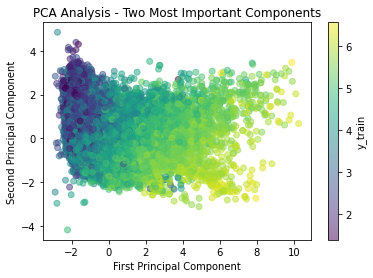

In [4]:
# Plot the PCA components
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train.iloc[:, 0], cmap='viridis', alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='y_train')
plt.title('PCA Analysis - Two Most Important Components')
plt.show()

In [5]:
print(X_train_pca.shape)
print(X_test_pca.shape)

y_train = np.array(y_train).reshape(-1)
print(y_train.shape)
y_test = np.array(y_test).reshape(-1)
print(y_test.shape)

(22270, 2)
(9545, 2)
(22270,)
(9545,)


In [6]:
final_result = pd.DataFrame(columns=["Model", "Train MSE", "Train MAE", "Test MSE", "Test MAE"])

## Linear Regression

In [7]:
# Perform linear regression
lr = LinearRegression()
lr.fit(X_train_pca, y_train)

# Make predictions
y_train_pred = lr.predict(X_train_pca)
y_test_pred = lr.predict(X_test_pca)

# Calculate MSE and MAE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print("MSE Train:", mse_train)
print("MSE Test:", mse_test)
print("MAE Train:", mae_train)
print("MAE Test:", mae_test)

final_result = final_result.append({"Model": "Linear Regression", "Train MSE": mse_train, "Train MAE": mae_train, "Test MSE": mse_test, "Test MAE": mae_test}, ignore_index=True)

MSE Train: 0.4231712879213385
MSE Test: 0.4314427661175179
MAE Train: 0.5150273500513588
MAE Test: 0.5206119321868025


<ipython-input-7-c9b8ce87a504>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_result = final_result.append({"Model": "Linear Regression", "Train MSE": mse_train, "Train MAE": mae_train, "Test MSE": mse_test, "Test MAE": mae_test}, ignore_index=True)


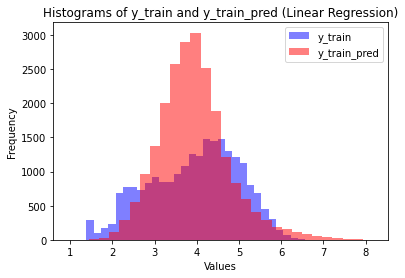

In [8]:
plt.hist(y_train, bins=30, alpha=0.5, label='y_train', color='blue')
plt.hist(y_train_pred, bins=30, alpha=0.5, label='y_train_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_train and y_train_pred (Linear Regression)')
plt.savefig("model/train-linear.pdf", format="pdf", bbox_inches="tight")
plt.show()

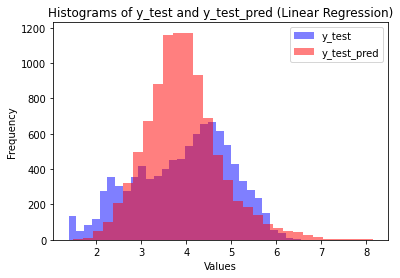

In [9]:
plt.hist(y_test, bins=30, alpha=0.5, label='y_test', color='blue')
plt.hist(y_test_pred, bins=30, alpha=0.5, label='y_test_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_test and y_test_pred (Linear Regression)')
plt.savefig("model_figures/test-linear.pdf", format="pdf", bbox_inches="tight")
plt.show()

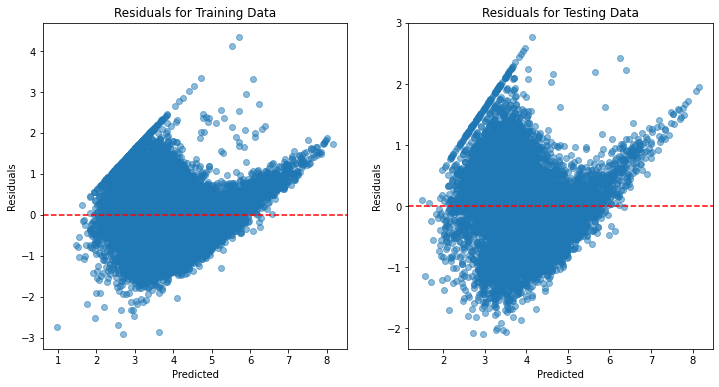

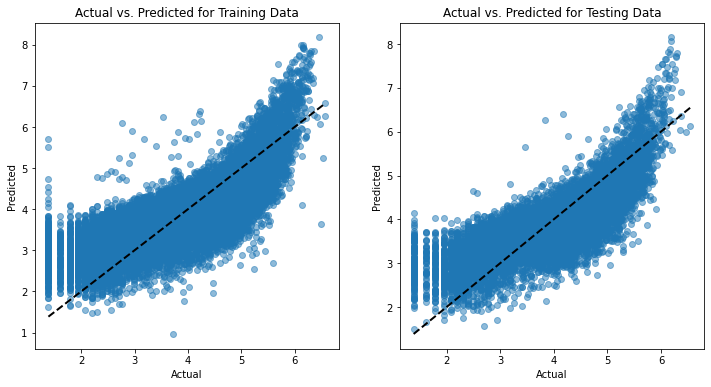

In [10]:
# Plot residuals for training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train_pred.ravel(), y_train_pred.ravel() - y_train, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals for Training Data')

# Plot residuals for testing data
plt.subplot(1, 2, 2)
plt.scatter(y_test_pred.ravel(), y_test_pred.ravel() - y_test, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals for Testing Data')
plt.show()

# Plot actual vs. predicted for training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred.ravel(), alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted for Training Data')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)

# Plot actual vs. predicted for testing data
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred.ravel(), alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted for Testing Data')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()


## Random Forest

In [11]:
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error, mean_absolute_error

# y_train = y_train.values.ravel()
# y_test = y_test.values.ravel()

def rf_optimization(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)
    
    rf = RandomForestRegressor(n_estimators=n_estimators,
                               max_depth=max_depth,
                               min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               random_state=42)
    rf.fit(X_train_pca, y_train)
    y_pred = rf.predict(X_test_pca)
    mse = mean_squared_error(y_test, y_pred)
    
    return -mse

bounds = {
    'n_estimators': (10, 200),
    'max_depth': (1, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4)
}

optimizer = BayesianOptimization(f=rf_optimization, pbounds=bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=25)

best_params_bayes = optimizer.max['params']
best_params_bayes['n_estimators'] = int(best_params_bayes['n_estimators'])
best_params_bayes['max_depth'] = int(best_params_bayes['max_depth'])
best_params_bayes['min_samples_split'] = int(best_params_bayes['min_samples_split'])
best_params_bayes['min_samples_leaf'] = int(best_params_bayes['min_samples_leaf'])

print("Best Parameters for Random Forest (Bayesian Optimization):", best_params_bayes)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -0.3948   | 11.86     | 3.852     | 7.856     | 123.7     |
| 2         | -0.3913   | 5.525     | 1.468     | 2.465     | 174.6     |
| 3         | -0.4183   | 18.43     | 3.124     | 2.165     | 194.3     |
| 4         | -0.448    | 25.14     | 1.637     | 3.455     | 44.85     |
| 5         | -0.3896   | 9.823     | 2.574     | 5.456     | 65.33     |
| 6         | -0.3918   | 10.27     | 1.594     | 5.349     | 64.5      |
| 7         | -0.5113   | 2.761     | 1.0       | 6.397     | 81.9      |
| 8         | -0.3865   | 7.268     | 2.085     | 3.709     | 162.2     |
| 9         | -0.4172   | 18.02     | 2.2       | 7.971     | 169.0     |
| 10        | -0.3914   | 5.182     | 2.209     | 4.234     | 148.4     |
| 11        | -0.4157   | 17.74     | 3.672     | 5.584     | 139.1     |
| 12        | -0.6741   | 1.112     | 

In [13]:
# Train and evaluate the best model
best_rf = RandomForestRegressor(**best_params_bayes, random_state=42)
best_rf.fit(X_train_pca, y_train)

y_train_pred_rf = best_rf.predict(X_train_pca)
y_test_pred_rf = best_rf.predict(X_test_pca)

mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)

print("Random Forest (Bayesian Optimization) MSE Train:", mse_train_rf)
print("Random Forest (Bayesian Optimization) MSE Test:", mse_test_rf)
print("Random Forest (Bayesian Optimization) MAE Train:", mae_train_rf)
print("Random Forest (Bayesian Optimization) MAE Test:", mae_test_rf)

## append to final_result
final_result = final_result.append({"Model": "Random Forest", "Train MSE": mse_train_rf, "Train MAE": mae_train_rf, "Test MSE": mse_test_rf, "Test MAE": mae_test_rf}, ignore_index=True)

Random Forest (Bayesian Optimization) MSE Train: 0.3577780824757443
Random Forest (Bayesian Optimization) MSE Test: 0.3865022301364563
Random Forest (Bayesian Optimization) MAE Train: 0.461644872079664
Random Forest (Bayesian Optimization) MAE Test: 0.4807817644396515


<ipython-input-13-0d67fad902ce>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_result = final_result.append({"Model": "Random Forest", "Train MSE": mse_train_rf, "Train MAE": mae_train_rf, "Test MSE": mse_test_rf, "Test MAE": mae_test_rf}, ignore_index=True)


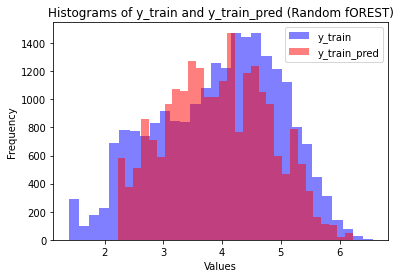

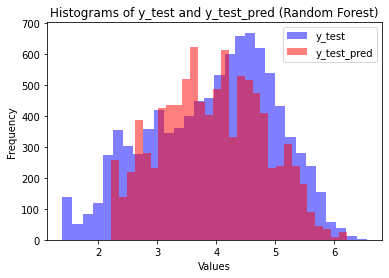

In [14]:
plt.hist(y_train, bins=30, alpha=0.5, label='y_train', color='blue')
plt.hist(y_train_pred_rf, bins=30, alpha=0.5, label='y_train_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_train and y_train_pred (Random fOREST)')
plt.savefig("model_figures/train-RF.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.hist(y_test, bins=30, alpha=0.5, label='y_test', color='blue')
plt.hist(y_test_pred_rf, bins=30, alpha=0.5, label='y_test_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_test and y_test_pred (Random Forest)')
plt.savefig("model_figures/test-RF.pdf", format="pdf", bbox_inches="tight")
plt.show()


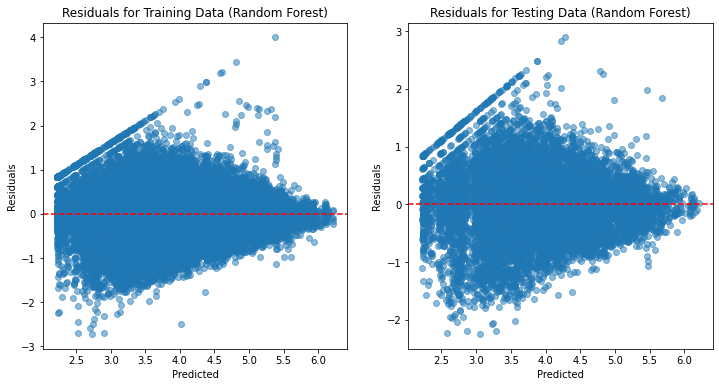

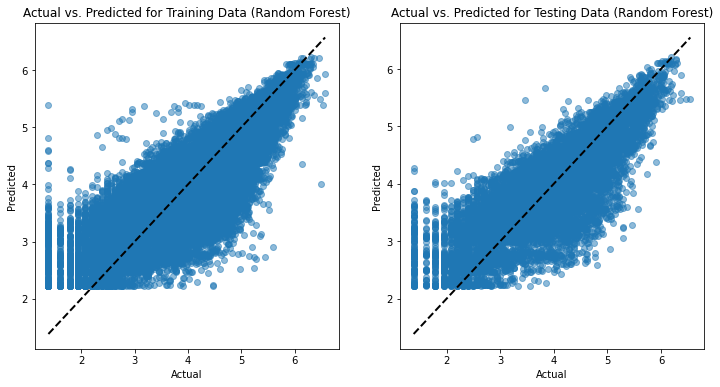

In [15]:
# Plot residuals for training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train_pred_rf, y_train_pred_rf - y_train, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals for Training Data (Random Forest)')

# Plot residuals for testing data
plt.subplot(1, 2, 2)
plt.scatter(y_test_pred_rf, y_test_pred_rf - y_test, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals for Testing Data (Random Forest)')
plt.show()

# Plot actual vs. predicted for training data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_rf, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted for Training Data (Random Forest)')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)

# Plot actual vs. predicted for testing data
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_rf, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted for Testing Data (Random Forest)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

## Linear GAM

In [16]:
from pygam import LinearGAM, s, l

# Define the model with splines for each variable
gam = LinearGAM(s(0) + s(1)).fit(X_train_pca, y_train)

lams = np.logspace(-3, 3, 10)
gam.gridsearch(X_train_pca, y_train, lam=lams)

y_train_pred_gam = gam.predict(X_train_pca)
mse_train_gam = mean_squared_error(y_train, y_train_pred_gam)
mae_train_gam = mean_absolute_error(y_train, y_train_pred_gam)

y_test_pred_gam = gam.predict(X_test_pca)
mse_test_gam = mean_squared_error(y_test, y_test_pred_gam)
mae_test_gam = mean_absolute_error(y_test, y_test_pred_gam)

print("Training Results (Linear GAM):")
print("Mean Squared Error:", mse_train_gam)
print("Mean Absolute Error:", mae_train_gam)

print("\nTesting Results (Linear GAM):")
print("Mean Squared Error:", mse_test_gam)
print("Mean Absolute Error:", mae_test_gam)

## append to final_result
final_result = final_result.append({"Model": "Frequentist Penalized GAM", "Train MSE": mse_train_gam, "Train MAE": mae_train_gam, "Test MSE": mse_test_gam, "Test MAE": mae_test_gam}, ignore_index=True)

  0% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 10% (1 of 10) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:02
 20% (2 of 10) |#####                    | Elapsed Time: 0:00:00 ETA:   0:00:02
 30% (3 of 10) |#######                  | Elapsed Time: 0:00:00 ETA:   0:00:02
 40% (4 of 10) |##########               | Elapsed Time: 0:00:01 ETA:   0:00:01
 50% (5 of 10) |############             | Elapsed Time: 0:00:01 ETA:   0:00:01
 60% (6 of 10) |###############          | Elapsed Time: 0:00:01 ETA:   0:00:01
 70% (7 of 10) |#################        | Elapsed Time: 0:00:02 ETA:   0:00:00
 80% (8 of 10) |####################     | Elapsed Time: 0:00:02 ETA:   0:00:00
 90% (9 of 10) |######################   | Elapsed Time: 0:00:02 ETA:   0:00:00
100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Training Results (Linear GAM):
Mean Squared Error: 0.3832310205365638
Mean Absolute Error: 0.48148072847209916

Testing Results (Linear GAM):
Mean Squared Error: 0.3901355313489811
Mean Absolute Error: 0.48672398223023683


<ipython-input-16-105a91ea1f86>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_result = final_result.append({"Model": "Frequentist Penalized GAM", "Train MSE": mse_train_gam, "Train MAE": mae_train_gam, "Test MSE": mse_test_gam, "Test MAE": mae_test_gam}, ignore_index=True)


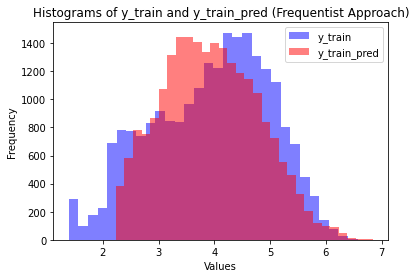

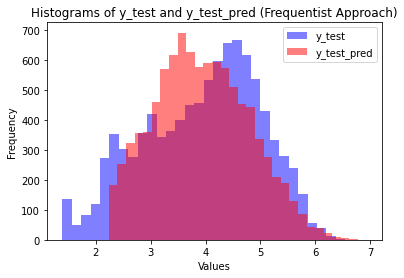

In [17]:
plt.hist(y_train, bins=30, alpha=0.5, label='y_train', color='blue')
plt.hist(y_train_pred_gam, bins=30, alpha=0.5, label='y_train_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_train and y_train_pred (Frequentist Approach)')
plt.savefig("model_figures/train-gam.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.hist(y_test, bins=30, alpha=0.5, label='y_test', color='blue')
plt.hist(y_test_pred_gam, bins=30, alpha=0.5, label='y_test_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_test and y_test_pred (Frequentist Approach)')
plt.savefig("mode_figures/test-gam.pdf", format="pdf", bbox_inches="tight")
plt.show()

## GAMMY

In [18]:
a = gammy.ExpSquared1d(
    np.arange(-4, 10, 0.1),
    corrlen=0.5,
    sigma=4.0,
    energy=0.9
)(x[:, 0])
b = gammy.ExpSquared1d(
    np.arange(-4, 10, 0.1),
    corrlen=0.5,
    sigma=4.0,
    energy=0.9
)(x[:, 1])
A = gammy.Kron(a, b)
bias = gammy.Scalar()
formula = A + bias

model = gammy.models.bayespy.GAM(formula).fit(X_train_pca, y_train)


In [19]:
y_train_pred_gammy1 = model.predict(X_train_pca)
mse_train_gam = mean_squared_error(y_train, y_train_pred_gammy1)
mae_train_gam = mean_absolute_error(y_train, y_train_pred_gammy1)

y_test_pred_gammy1 = model.predict(X_test_pca)
mse_test_gam = mean_squared_error(y_test, y_test_pred_gammy1)
mae_test_gam = mean_absolute_error(y_test, y_test_pred_gammy1)

print("Training Results (Gammy with Exp-Squared):")
print("Mean Squared Error:", mse_train_gam)
print("Mean Absolute Error:", mae_train_gam)

print("\nTesting Results (Gammy with Exp-Squared):")
print("Mean Squared Error:", mse_test_gam)
print("Mean Absolute Error:", mae_test_gam)

## append to final_result
final_result = final_result.append({"Model": "Gaussian Process Prior (Exp-Squared)", "Train MSE": mse_train_gam, "Train MAE": mae_train_gam, "Test MSE": mse_test_gam, "Test MAE": mae_test_gam}, ignore_index=True)

Training Results (Gammy with Exp-Squared):
Mean Squared Error: 0.37408062690504584
Mean Absolute Error: 0.47191316920384896

Testing Results (Gammy with Exp-Squared):
Mean Squared Error: 0.3844590305600841
Mean Absolute Error: 0.4798603082695333


<ipython-input-19-fb26e2e15d0a>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_result = final_result.append({"Model": "Gaussian Process Prior (Exp-Squared)", "Train MSE": mse_train_gam, "Train MAE": mae_train_gam, "Test MSE": mse_test_gam, "Test MAE": mae_test_gam}, ignore_index=True)


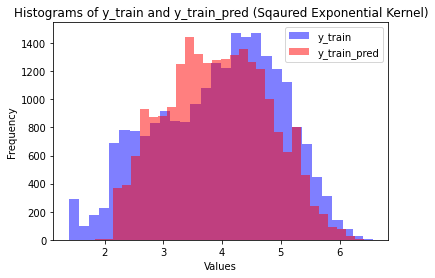

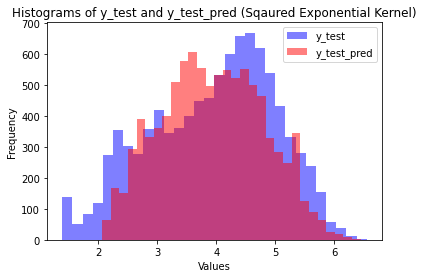

In [20]:
plt.hist(y_train, bins=30, alpha=0.5, label='y_train', color='blue')
plt.hist(y_train_pred_gammy1, bins=30, alpha=0.5, label='y_train_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_train and y_train_pred (Sqaured Exponential Kernel)')
plt.savefig("model_figures/train-gp-exp.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.hist(y_test, bins=30, alpha=0.5, label='y_test', color='blue')
plt.hist(y_test_pred_gammy1, bins=30, alpha=0.5, label='y_test_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_test and y_test_pred (Sqaured Exponential Kernel)')
plt.savefig("model_figures/test-gp-exp.pdf", format="pdf", bbox_inches="tight")
plt.show()

### GAMMY with Rational Quadratic Kernel

In [21]:
a = gammy.RationalQuadratic1d(
    np.arange(-4, 10, 0.1),
    corrlen=0.5,
    alpha=1,
    sigma=4.0,
    energy=0.9
)(x[:, 0])
b = gammy.RationalQuadratic1d(
    np.arange(-4, 10, 0.1),
    corrlen=0.5,
    alpha=1,
    sigma=4.0,
    energy=0.9
)(x[:, 1])
A = gammy.Kron(a, b)
bias = gammy.Scalar()
formula = A + bias

model = gammy.models.bayespy.GAM(formula).fit(X_train_pca, y_train)

In [22]:
y_train_pred_gammy2 = model.predict(X_train_pca)
mse_train_gam = mean_squared_error(y_train, y_train_pred_gammy2)
mae_train_gam = mean_absolute_error(y_train, y_train_pred_gammy2)

y_test_pred_gammy2 = model.predict(X_test_pca)
mse_test_gam = mean_squared_error(y_test, y_test_pred_gammy2)
mae_test_gam = mean_absolute_error(y_test, y_test_pred_gammy2)

print("Training Results (Gammy with Rational Quadratic):")
print("Mean Squared Error:", mse_train_gam)
print("Mean Absolute Error:", mae_train_gam)

print("\nTesting Results (Gammy with Rational Quadratic):")
print("Mean Squared Error:", mse_test_gam)
print("Mean Absolute Error:", mae_test_gam)

## append to final_result
final_result = final_result.append({"Model": "Gaussian Process Prior (Rational Quadratic)", "Train MSE": mse_train_gam, "Train MAE": mae_train_gam, "Test MSE": mse_test_gam, "Test MAE": mae_test_gam}, ignore_index=True)

Training Results (Gammy with Rational Quadratic):
Mean Squared Error: 0.3743160100531522
Mean Absolute Error: 0.47208773912699353

Testing Results (Gammy with Rational Quadratic):
Mean Squared Error: 0.3842139623197003
Mean Absolute Error: 0.4795802419994979


<ipython-input-22-522a3bf5c6cb>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_result = final_result.append({"Model": "Gaussian Process Prior (Rational Quadratic)", "Train MSE": mse_train_gam, "Train MAE": mae_train_gam, "Test MSE": mse_test_gam, "Test MAE": mae_test_gam}, ignore_index=True)


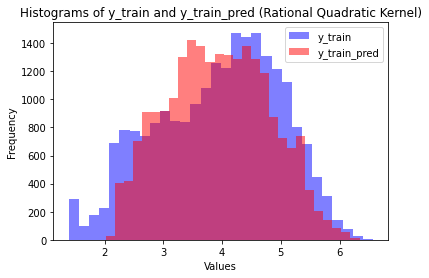

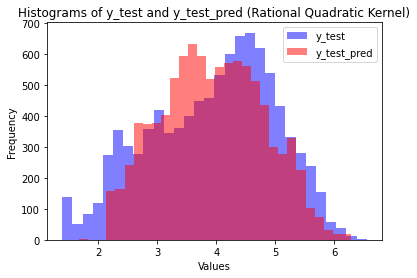

In [23]:
plt.hist(y_train, bins=30, alpha=0.5, label='y_train', color='blue')
plt.hist(y_train_pred_gammy2, bins=30, alpha=0.5, label='y_train_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_train and y_train_pred (Rational Quadratic Kernel)')
plt.savefig("model_figures/train-gp-rq.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.hist(y_test, bins=30, alpha=0.5, label='y_test', color='blue')
plt.hist(y_test_pred_gammy2, bins=30, alpha=0.5, label='y_test_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_test and y_test_pred (Rational Quadratic Kernel)')
plt.savefig("model_figures/test-gp-rq.pdf", format="pdf", bbox_inches="tight")
plt.show()

### GAMMY with Orn Uhl

In [24]:
import gammy
from gammy.arraymapper import x
from gammy.models.bayespy import GAM

a = gammy.OrnsteinUhlenbeck1d(
    np.arange(-4, 10, 0.5),
    corrlen=0.5,
    sigma=4.0,
    energy=0.9
)(x[:, 0])
b = gammy.OrnsteinUhlenbeck1d(
    np.arange(-4, 10, 0.5),
    corrlen=0.5,
    sigma=4.0,
    energy=0.9
)(x[:, 1])
A = gammy.Kron(a, b)
formula = A 

orn_uhl_model = gammy.models.bayespy.GAM(formula).fit(X_train_pca, y_train)


In [25]:
y_train_pred_gammy3 = orn_uhl_model.predict(X_train_pca)
mse_train_gam = mean_squared_error(y_train, y_train_pred_gammy3)
mae_train_gam = mean_absolute_error(y_train, y_train_pred_gammy3)

y_test_pred_gammy3 = orn_uhl_model.predict(X_test_pca)
mse_test_gam = mean_squared_error(y_test, y_test_pred_gammy3)
mae_test_gam = mean_absolute_error(y_test, y_test_pred_gammy3)

print("Training Results (Gammy with Rational Quadratic):")
print("Mean Squared Error:", mse_train_gam)
print("Mean Absolute Error:", mae_train_gam)

print("\nTesting Results (Gammy with Rational Quadratic):")
print("Mean Squared Error:", mse_test_gam)
print("Mean Absolute Error:", mae_test_gam)

## append to final_result
final_result = final_result.append({"Model": "Gaussian Process Prior (Ornstein Uhlenbeck)", "Train MSE": mse_train_gam, "Train MAE": mae_train_gam, "Test MSE": mse_test_gam, "Test MAE": mae_test_gam}, ignore_index=True)

Training Results (Gammy with Rational Quadratic):
Mean Squared Error: 0.3729454048086871
Mean Absolute Error: 0.47096525768865716

Testing Results (Gammy with Rational Quadratic):
Mean Squared Error: 0.3877005181457266
Mean Absolute Error: 0.4809516602991452


<ipython-input-25-b25a9fd6f003>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_result = final_result.append({"Model": "Gaussian Process Prior (Ornstein Uhlenbeck)", "Train MSE": mse_train_gam, "Train MAE": mae_train_gam, "Test MSE": mse_test_gam, "Test MAE": mae_test_gam}, ignore_index=True)


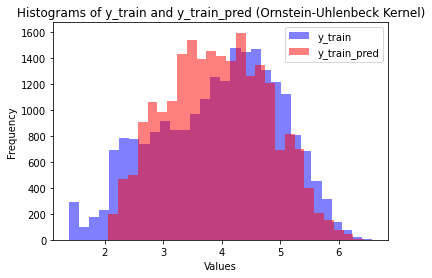

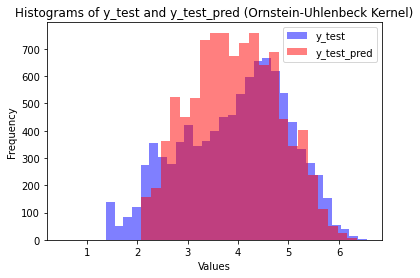

In [26]:
plt.hist(y_train, bins=30, alpha=0.5, label='y_train', color='blue')
plt.hist(y_train_pred_gammy3, bins=30, alpha=0.5, label='y_train_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_train and y_train_pred (Ornstein-Uhlenbeck Kernel)')
plt.savefig("model_figures/train-gp-orn.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.hist(y_test, bins=30, alpha=0.5, label='y_test', color='blue')
plt.hist(y_test_pred_gammy3, bins=30, alpha=0.5, label='y_test_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_test and y_test_pred (Ornstein-Uhlenbeck Kernel)')
plt.savefig("model_figures/test-gp-orn.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Difference Priors

In [29]:
first_component = X_train_pca[:, 0]
second_component = X_train_pca[:, 1]
first_test = X_test_pca[:, 0]
second_test = X_test_pca[:, 1]
data = pd.DataFrame({'x1': first_component, 'x2': second_component, 'y': y_train})
test_data = pd.DataFrame({'x1': first_test, 'x2': second_test, 'y': y_test})

In [32]:
grids = (np.linspace(-4,10,60), np.linspace(-4,10,60))
shape = [len(x) for x in grids]

# diff priors along different dimensions 
D1 = bp.utils.diffmatn(shape, 0, order=2)
D2 = bp.utils.diffmatn(shape, 1, order=3)
D = sparse.vstack((D1,D2))

# prior variances
pri_var = np.concatenate((1*np.ones(D1.shape[0]), 1*np.ones(D2.shape[0])))

# GAM specification for 2d fit
gam_spec = [
    {
        'fun': lambda df: custom_interp_matrix_2d(df[['x1', 'x2']].values, grids),
        'name': 'smoothfun_2d',
        'prior': {
            'B': D,
            'mu': np.zeros(D.shape[0]),
            'cov': pri_var
        }
    }
]

In [33]:
model = bp.models.GamModel('y', gam_spec).fit(data, obs_cov=0.01**2)
y_train_pred = model.predict(data)
print("Mean square error for training data", mean_squared_error(y_train_pred, y_train))
print("Mean absolute error for training data", mean_absolute_error(y_train_pred, y_train))
y_test_pred = model.predict(test_data)
print("Mean square error for testing data", mean_squared_error(y_test_pred, y_test))
print("Mean absolute error for testing data", mean_absolute_error(y_test_pred, y_test))

## append to final_result
final_result = final_result.append({"Model": "Difference Priors, f(x1,x2)", "Train MSE": mean_squared_error(y_train_pred, y_train), "Train MAE": mean_absolute_error(y_train_pred, y_train), "Test MSE": mean_squared_error(y_test_pred, y_test), "Test MAE": mean_absolute_error(y_test_pred, y_test)}, ignore_index=True)

Mean square error for training data 0.4955986148223525
Mean absolute error for training data 0.5557342466437951
Mean square error for testing data 0.5779638840930852
Mean absolute error for testing data 0.6106242096953184


<ipython-input-33-7d5fd79ccbbb>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_result = final_result.append({"Model": "Difference Priors, f(x1,x2)", "Train MSE": mean_squared_error(y_train_pred, y_train), "Train MAE": mean_absolute_error(y_train_pred, y_train), "Test MSE": mean_squared_error(y_test_pred, y_test), "Test MAE": mean_absolute_error(y_test_pred, y_test)}, ignore_index=True)


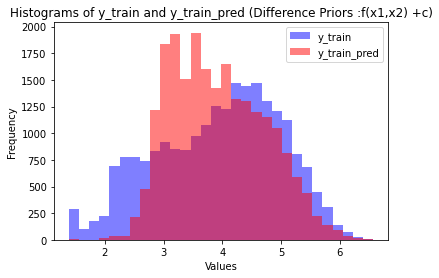

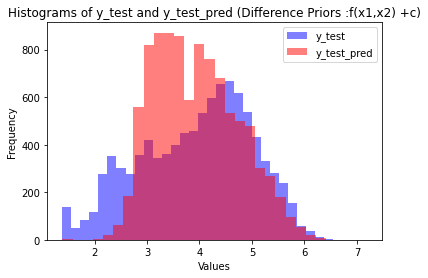

In [34]:
plt.hist(y_train, bins=30, alpha=0.5, label='y_train', color='blue')
plt.hist(y_train_pred, bins=30, alpha=0.5, label='y_train_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_train and y_train_pred (Difference Priors :f(x1,x2) +c)')
plt.savefig("model_figures/train-blipy.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.hist(y_test, bins=30, alpha=0.5, label='y_test', color='blue')
plt.hist(y_test_pred, bins=30, alpha=0.5, label='y_test_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_test and y_test_pred (Difference Priors :f(x1,x2) +c)')
plt.savefig("model_figures/test-blipy.pdf", format="pdf", bbox_inches="tight")
plt.show()


#### Difference Priors f(x1) + f(x2)

In [35]:
x1_fit = np.linspace(-4, 10, 60)
x2_fit = np.linspace(-4, 10, 60)
nfit = len(x2_fit)

gam_specs = lambda logv: [
    smooth_diff1('x1', x1_fit, diff_std=np.exp(logv[0]), mu=np.mean(data.y.values), std=1),
    {
        'fun': lambda df: custom_interp_matrix_1d(df['x2'].values, x2_fit),
        'name': 'f(x2)',
        'prior': {
            'B': bp.utils.diffmat(nfit, order=2, periodic=True),
            'mu': np.zeros(nfit),
            'cov': np.concatenate((np.exp(logv[1])*np.ones(nfit-2), 0.00001*np.ones(2))),
        }
    }
]

In [36]:
model = bp.models.GamModel('y', gam_specs((np.log(0.001), np.log(0.1)))).fit(data, obs_cov=0.1**2)
y_train_pred = model.predict(data)
print("Mean square error for training data", mean_squared_error(y_train_pred, y_train))
print("Mean absolute error for training data", mean_absolute_error(y_train_pred, y_train))
y_test_pred = model.predict(test_data)
print("Mean square error for testing data", mean_squared_error(y_test_pred, y_test))
print("Mean absolute error for testing data", mean_absolute_error(y_test_pred, y_test))

final_result = final_result.append({"Model": "Difference Priors, f(x1)+f(x2)", "Train MSE": mean_squared_error(y_train_pred, y_train), "Train MAE": mean_absolute_error(y_train_pred, y_train), "Test MSE": mean_squared_error(y_test_pred, y_test), "Test MAE": mean_absolute_error(y_test_pred, y_test)}, ignore_index=True)

Mean square error for training data 0.38543474960869006
Mean absolute error for training data 0.48329530969419293
Mean square error for testing data 0.39136062200080096
Mean absolute error for testing data 0.48821834441146233


<ipython-input-36-fa52d1e38781>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_result = final_result.append({"Model": "Difference Priors, f(x1)+f(x2)", "Train MSE": mean_squared_error(y_train_pred, y_train), "Train MAE": mean_absolute_error(y_train_pred, y_train), "Test MSE": mean_squared_error(y_test_pred, y_test), "Test MAE": mean_absolute_error(y_test_pred, y_test)}, ignore_index=True)


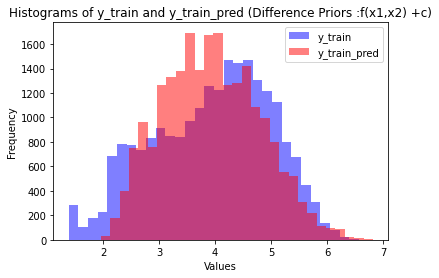

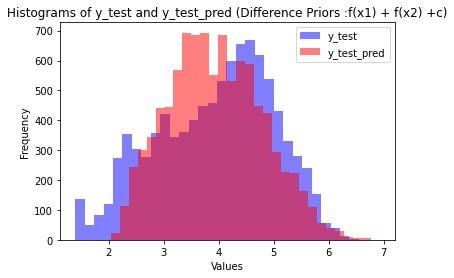

In [37]:
plt.hist(y_train, bins=30, alpha=0.5, label='y_train', color='blue')
plt.hist(y_train_pred, bins=30, alpha=0.5, label='y_train_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_train and y_train_pred (Difference Priors :f(x1,x2) +c)')
plt.savefig("model_figures/train-blipy-split.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.hist(y_test, bins=30, alpha=0.5, label='y_test', color='blue')
plt.hist(y_test_pred, bins=30, alpha=0.5, label='y_test_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_test and y_test_pred (Difference Priors :f(x1) + f(x2) +c)')
plt.savefig("model_figures/test-blipy-split.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### Bayesian Optimization with likelihood for the above data

In [39]:
like = lambda v: bp.models.GamModel('y', gam_specs(v)).fit(data, obs_cov=0.5**2).L

In [40]:
v0=(np.log(0.001), np.log(0.1))
model_like = bp.models.GamModel('y', gam_specs(minimize(like, v0, method='Nelder-Mead').x)).fit(data, obs_cov=0.5**2)

In [41]:

y_train_pred = model_like.predict(data)
print("Mean square error for training data", mean_squared_error(y_train_pred, y_train))
print("Mean absolute error for training data", mean_absolute_error(y_train_pred, y_train))
y_test_pred = model_like.predict(test_data)
print("Mean square error for testing data", mean_squared_error(y_test_pred, y_test))
print("Mean absolute error for testing data", mean_absolute_error(y_test_pred, y_test))

final_result = final_result.append({"Model": "Difference Priors, f(x1)+f(x2) Optimized", "Train MSE": mean_squared_error(y_train_pred, y_train), "Train MAE": mean_absolute_error(y_train_pred, y_train), "Test MSE": mean_squared_error(y_test_pred, y_test), "Test MAE": mean_absolute_error(y_test_pred, y_test)}, ignore_index=True)

Mean square error for training data 0.3856838457147047
Mean absolute error for training data 0.4831770997238902
Mean square error for testing data 0.3910495439777918
Mean absolute error for testing data 0.48795093745184825


<ipython-input-41-270ab078eb64>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_result = final_result.append({"Model": "Difference Priors, f(x1)+f(x2) Optimized", "Train MSE": mean_squared_error(y_train_pred, y_train), "Train MAE": mean_absolute_error(y_train_pred, y_train), "Test MSE": mean_squared_error(y_test_pred, y_test), "Test MAE": mean_absolute_error(y_test_pred, y_test)}, ignore_index=True)


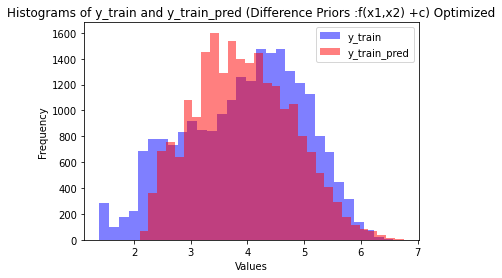

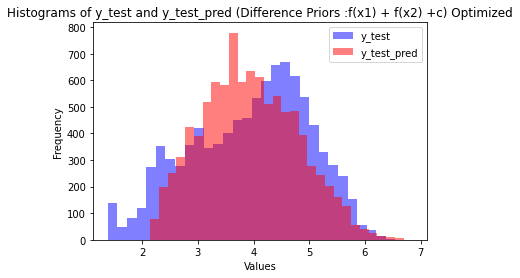

In [44]:
plt.hist(y_train, bins=30, alpha=0.5, label='y_train', color='blue')
plt.hist(y_train_pred, bins=30, alpha=0.5, label='y_train_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_train and y_train_pred (Difference Priors :f(x1,x2) +c) Optimized')
plt.savefig("model_figures/train-blipy-split-op.pdf", format="pdf", bbox_inches="tight")
plt.show()

plt.hist(y_test, bins=30, alpha=0.5, label='y_test', color='blue')
plt.hist(y_test_pred, bins=30, alpha=0.5, label='y_test_pred', color='red')

plt.legend(loc='best')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histograms of y_test and y_test_pred (Difference Priors :f(x1) + f(x2) +c) Optimized')
plt.savefig("model_figures/test-blipy-split-op.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [43]:
final_result.head(11)

,Model,Train MSE,Train MAE,Test MSE,Test MAE
0,Linear Regression,0.423171,0.515027,0.431443,0.520612
1,Random Forest,0.357778,0.461645,0.386502,0.480782
2,Random Forest,0.357778,0.461645,0.386502,0.480782
3,Frequentist Penalized GAM,0.383231,0.481481,0.390136,0.486724
4,Gaussian Process Prior (Exp-Squared),0.374081,0.471913,0.384459,0.479860
5,Gaussian Process Prior (Rational Quadratic),0.374316,0.472088,0.384214,0.479580
6,Gaussian Process Prior (Ornstein Uhlenbeck),0.372945,0.470965,0.387701,0.480952
7,"Difference Priors, f(x1,x2)",0.495602,0.555859,0.577610,0.610372
8,"Difference Priors, f(x1,x2)",0.495599,0.555734,0.577964,0.610624
9,"Difference Priors, f(x1)+f(x2)",0.385435,0.483295,0.391361,0.488218
